## NBA GM Trades Analysis - Part 2 Analysis

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import time
import json
from bs4 import BeautifulSoup
import matplotlib.image as mpimg
from PIL import Image

In [ ]:
!pip install pandas numpy matplotlib seaborn requests beautifulsoup4 pillow

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
trades_df = pd.read_csv('../outputs/trade_acquired_win_shares_2022_2024.csv')

## Aggregation and Visualization

### Cost per Win Share

In [4]:
# Convert 'AAV' and 'Acquired Player BPM/WARP Year 1' to numeric, coercing errors to NaN
trades_df['AAV'] = pd.to_numeric(trades_df['AAV'], errors='coerce')
trades_df['Acquired Player Win Shares Year 1'] = pd.to_numeric(trades_df['Acquired Player Win Shares Year 1'], errors='coerce')

# Group by 'Acquiring GM' and 'Team Acquiring', then calculate the sum and count
grouped_year1 = trades_df.groupby(['Acquiring GM', 'Team Acquiring']).agg({
    'AAV': 'sum',
    'Acquired Player Win Shares Year 1': 'sum',
    'Acquiring GM': 'count'  # Using 'count' to get the number of entries per group
})

# Rename the count column for clarity
grouped_year1 = grouped_year1.rename(columns={'Acquiring GM': 'Count'})

# Calculate the ratio of AAV to Acquired Player BPM/WARP Year 1
grouped_year1['Cost of Win Share'] = grouped_year1['AAV'] / grouped_year1['Acquired Player Win Shares Year 1']

# Reset index for easier plotting
grouped_year1 = grouped_year1.reset_index()

In [5]:
grouped_year1 = grouped_year1.rename(columns={'AAV': 'AAV_sum'})

In [6]:
filtered_df = trades_df.copy()

# Convert 'AAV' and 'Acquired Player BPM/WARP Year 1' to numeric, coercing errors to NaN
filtered_df['AAV'] = pd.to_numeric(filtered_df['AAV'], errors='coerce')
filtered_df['Acquired Player Win Shares Year 1'] = pd.to_numeric(filtered_df['Acquired Player Win Shares Year 1'], errors='coerce')

# Group by 'Team Acquiring' and calculate the sum of 'AAV' and 'Acquired Player BPM/WARP Year 1'
grouped_against = filtered_df.groupby('Losing GM').agg({
    'AAV': 'sum',
    'Acquired Player Win Shares Year 1': 'sum'
})

# Calculate the ratio of AAV to Acquired Player BPM/WARP Year 1
grouped_against['Cost of Win Share'] = grouped_against['AAV'] / grouped_against['Acquired Player Win Shares Year 1']

# Reset index for easier plotting
grouped_against = grouped_against.reset_index()

In [7]:
# Merge the two DataFrames on 'Team Acquiring' and 'Team Losing'
grouped_difference = pd.merge(grouped_year1, grouped_against, 
                              left_on='Acquiring GM', right_on='Losing GM', 
                              suffixes=('_acquired', '_losing'))

# Calculate the final ratio by dividing the AAV_to_WS of acquired over the AAV_to_WS of losing
grouped_difference['final_ratio'] = grouped_difference['Cost of Win Share_losing'] / grouped_difference['Cost of Win Share_acquired']

# Select only the relevant columns for the result
grouped_difference = grouped_difference[['Team Acquiring','Acquiring GM', 'final_ratio']]

In [8]:
grouped_difference

,Team Acquiring,Acquiring GM,final_ratio
0,MIA,Andy Elisburg,1.375659
1,TOR,Bobby Webster,0.529115
2,BOS,Brad Stevens,2.046187
3,SAS,Brian Wright,0.274268
4,DEN,Calvin Booth,9.022556
5,IND,Chad Buchanan,0.959281
6,PHI,Daryl Morey,1.056028
7,PHO,James Jones,1.315593
8,POR,Joe Cronin,0.649183
9,MIL,Jon Horst,0.541850


In [9]:
grouped_difference = grouped_difference[np.isfinite(grouped_difference['final_ratio'])]

C:\Users\kevin\AppData\Local\Temp\ipykernel_53976\1498359550.py:42: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((90, 44), Image.ANTIALIAS)  # Increased size to 90x44
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


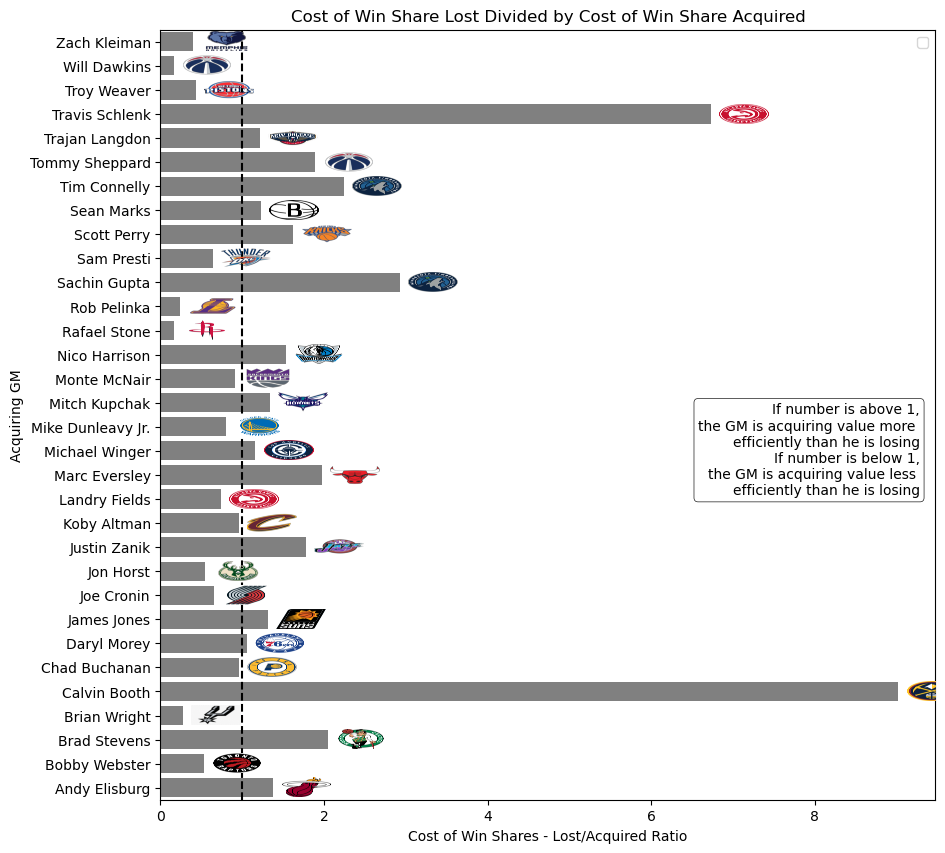

In [10]:
# Set up the plot size with reduced height
plt.figure(figsize=(10, 10))  # Adjust the height here

# Create a horizontal bar chart using seaborn
sns.barplot(y='Acquiring GM', x='final_ratio', data=grouped_difference, color='gray')

# Add labels and title
plt.title('Cost of Win Share Lost Divided by Cost of Win Share Acquired')
plt.xlabel('Cost of Win Shares - Lost/Acquired Ratio')
plt.ylabel('Acquiring GM')

# Set the x-axis limits to show only positive values
plt.xlim(0, plt.xlim()[1])  # Lower limit is set to 0, upper limit remains unchanged

# Set the y-axis limits to keep bars within a certain height
plt.ylim(-0.5, len(grouped_difference) - 0.5)  # Adjust y-axis limits to fit the number of bars

# Add a black reference line for the modeled cost of a win share
plt.axvline(x=1, color='black', linestyle='--')

# Add an annotation with a multi-line text box aligned to the far right
plt.text(
    x=plt.xlim()[1] * 0.98,  # Position near the far right of the x-axis
    y=len(grouped_difference) * 0.5,  # Adjusted vertical position
    s="If number is above 1,\nthe GM is acquiring value more \nefficiently than he is losing\nIf number is below 1,\nthe GM is acquiring value less \nefficiently than he is losing",
    ha='right',  # Align text to the right
    va='top',  # Vertical alignment to the top
    color='black',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", linewidth=0.5, alpha=0.9),
)

# Add larger team logos to the right of each bar
for i, (index, row) in enumerate(grouped_difference.iterrows()):
    team_name = row['Team Acquiring']  # Assuming 'Team Acquiring' has the team names
    logo_path = f'../logos/{team_name}.png'  # Update with actual path to logos
    
    # Load the logo image
    img = Image.open(logo_path)
    
    # Resize the image (width, height) - 100% larger than previous size
    img = img.resize((90, 44), Image.ANTIALIAS)  # Increased size to 90x44
    img = mpimg.imread(logo_path)  # Convert back to numpy array after resizing
    
    # Set the position for the logo to the right of each bar
    plt.imshow(img, aspect='auto', extent=[row['final_ratio'] + 0.1, row['final_ratio'] + 0.7, 
                                            i - 0.4, i + 0.4], zorder=5)

# Align y-axis labels with bars by setting the ticks and labels manually
plt.yticks(ticks=range(len(grouped_difference)), labels=grouped_difference['Acquiring GM'], rotation=0)

# Add a legend for the reference line
plt.legend()

# Show the plot
plt.show()

In [13]:
trades_df[trades_df['Acquiring GM'] == 'Calvin Booth']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
78,2022,DEN,Bryn Forbes,SAS,Trade,Calvin Booth,Brian Wright,2023,2022Bryn Forbes,4.5,0.7,NaN
134,2023,DEN,Kentavious Caldwell-Pope,WAS,Trade,Calvin Booth,Will Dawkins,2024,2023Kentavious Caldwell-Pope,14.0,4.5,4.8
135,2023,DEN,Ish Smith,WAS,Trade,Calvin Booth,Will Dawkins,2024,2023Ish Smith,1.8,-0.5,NaN
192,2023,DEN,Thomas Bryant,LAL,Trade,Calvin Booth,Rob Pelinka,2024,2023Thomas Bryant,2.5,0.3,NaN


In [14]:
trades_df[trades_df['Losing GM'] == 'Calvin Booth']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
76,2022,BOS,Bol Bol,DEN,Trade,Brad Stevens,Calvin Booth,2023,2022Bol Bol,2.2,0.0,NaN
77,2022,BOS,PJ Dozier,DEN,Trade,Brad Stevens,Calvin Booth,2023,2022PJ Dozier,2.0,0.0,NaN
136,2023,WAS,Will Barton,DEN,Trade,Will Dawkins,Calvin Booth,2024,2023Will Barton,13.2,0.2,NaN
137,2023,WAS,Monté Morris,DEN,Trade,Will Dawkins,Calvin Booth,2024,2023Monté Morris,9.1,0.0,NaN
193,2023,LAC,Bones Hyland,DEN,Trade,Michael Winger,Calvin Booth,2024,2023Bones Hyland,2.3,0.5,0.0


In [15]:
# Define the grade categories
grade_labels = ['F', 'D', 'C', 'B', 'A']

# Calculate the quantiles for the 'final_ratio' column (5 bins for grades A to F)
grouped_difference['Grade'] = pd.qcut(grouped_difference['final_ratio'], q=5, labels=grade_labels)

C:\Users\kevin\AppData\Local\Temp\ipykernel_53976\1230334830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_difference['Grade'] = pd.qcut(grouped_difference['final_ratio'], q=5, labels=grade_labels)


In [16]:
# Calculate the mean and standard deviation of the 'GM_Pct Change' column
mean_gm_pct_change = grouped_difference['final_ratio'].mean()
std_gm_pct_change = grouped_difference['final_ratio'].std()

# Create the 'z score' column by applying the Z-score formula
grouped_difference['z score'] = (grouped_difference['final_ratio'] - mean_gm_pct_change) / std_gm_pct_change

C:\Users\kevin\AppData\Local\Temp\ipykernel_53976\3762698852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_difference['z score'] = (grouped_difference['final_ratio'] - mean_gm_pct_change) / std_gm_pct_change


In [17]:
grouped_difference.sort_values('final_ratio', ascending=False)

,Team Acquiring,Acquiring GM,final_ratio,Grade,z score
4,DEN,Calvin Booth,9.022556,A,4.129177
28,ATL,Travis Schlenk,6.730435,A,2.866391
21,MIN,Sachin Gupta,2.928571,A,0.771851
25,MIN,Tim Connelly,2.241315,A,0.393225
2,BOS,Brad Stevens,2.046187,A,0.285724
13,CHI,Marc Eversley,1.969637,A,0.243551
26,WAS,Tommy Sheppard,1.893800,A,0.201771
10,UTA,Justin Zanik,1.775148,B,0.136402
23,NYK,Scott Perry,1.626185,B,0.054335
18,DAL,Nico Harrison,1.538331,B,0.005934


In [ ]:
grouped_difference.to_csv('../outputs/trades_gm_z_scores_2022_2024.csv', index=False)

In [17]:
trades_df[trades_df['Acquiring GM'] == 'Travis Schlenk']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
40,2022,ATL,Delon Wright,SAC,Trade,Travis Schlenk,Monte McNair,2023,2022Delon Wright,8.0,3.6,NaN
73,2022,ATL,Kevin Knox II,NYK,Trade,Travis Schlenk,Scott Perry,2023,2022Kevin Knox II,5.8,0.0,NaN


In [18]:
trades_df[trades_df['Losing GM'] == 'Travis Schlenk']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
41,2022,BOS,Kris Dunn,ATL,Trade,Brad Stevens,Travis Schlenk,2023,2022Kris Dunn,4.0,0.0,NaN
42,2022,BOS,Bruno Fernando,ATL,Trade,Brad Stevens,Travis Schlenk,2023,2022Bruno Fernando,1.8,0.1,NaN
74,2022,NYK,Solomon Hill,ATL,Trade,Scott Perry,Travis Schlenk,2023,2022Solomon Hill,2.4,0.0,NaN
75,2022,NYK,Cam Reddish,ATL,Trade,Scott Perry,Travis Schlenk,2023,2022Cam Reddish,4.7,0.4,0.7


In [19]:
trades_df[trades_df['Acquiring GM'] == 'Sachin Gupta']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
13,2022,MIN,Tauren Prince,CLE,Trade,Sachin Gupta,Koby Altman,2023,2022Tauren Prince,7.3,0.0,NaN
58,2022,MIN,Patrick Beverley,MEM,Trade,Sachin Gupta,Zach Kleiman,2023,2022Patrick Beverley,13.0,4.1,NaN


In [20]:
trades_df[trades_df['Losing GM'] == 'Sachin Gupta']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
14,2022,CLE,Ricky Rubio,MIN,Trade,Koby Altman,Sachin Gupta,2023,2022Ricky Rubio,17.0,1.3,0.7
56,2022,MEM,Jarrett Culver,MIN,Trade,Zach Kleiman,Sachin Gupta,2023,2022Jarrett Culver,1.0,0.1,NaN
57,2022,MEM,Juancho Hernangómez,MIN,Trade,Zach Kleiman,Sachin Gupta,2023,2022Juancho Hernangómez,2.3,0.0,NaN


Checked the transactions for Calvin Booth, Travis Schlenk, and Sachin Gupta in my analysis to see why they got A. My initial theory after seeing Calvin Booth is that if you shed a lot of salary you will be graded well but it seems in the other two cases they are taking on just as much salary as they are giving up.

### Trying to find patterns and correlations

In [18]:
df_for = pd.merge(grouped_year1, grouped_difference, on='Acquiring GM', how='inner')
df_against = pd.merge(grouped_against, grouped_difference, left_on='Losing GM', right_on='Acquiring GM', how='inner')

In [22]:
df_for.columns

Index(['Acquiring GM', 'Team Acquiring_x', 'AAV_sum',
       'Acquired Player Win Shares Year 1', 'Count', 'Cost of Win Share',
       'Team Acquiring_y', 'final_ratio', 'Grade'],
      dtype='object')

In [23]:
df_against.columns

Index(['Losing GM', 'AAV', 'Acquired Player Win Shares Year 1',
       'Cost of Win Share', 'Team Acquiring', 'Acquiring GM', 'final_ratio',
       'Grade'],
      dtype='object')

In [24]:
df_for['AAV_sum'].corr(df_for['final_ratio'])

-0.32430265224478166

This correlation between the sum of salaries is the highest correlation to the final ratio. This suggests that usually for trades bringing on less salary leads to more efficiency in acquiring value for dollars.

In [25]:
df_against['AAV'].corr(df_for['final_ratio'])

-0.20019683738989233

In [26]:
df_for['Count'].corr(df_for['final_ratio'])

-0.3048944582626991

In [27]:
df_for['avg_salary'] = df_for['AAV_sum'] / df_for['Count']

In [28]:
df_for['avg_salary'].corr(df_for['final_ratio'])

-0.1013483160886167

In [29]:
df_for['Cost of Win Share'].corr(df_for['final_ratio'])

-0.39420444293579837

In [29]:
grouped_difference.columns

Index(['Team Acquiring', 'Acquiring GM', 'final_ratio', 'Grade'], dtype='object')

### A Second Way of Grading GM - Win Shares Acquired over Lost

Instead of using the cost per win share, this method analyzes win shares directly. This method may not be as effective because some GMs are managing tanking teams and are not trying to acquire win shares in return. However, it is an additional look and I believe this is more representative of trade performance because GMs are often not around years down the line for future looking trades to pay off in their favor.

In [19]:
# Merge the two DataFrames on 'Team Acquiring' and 'Team Losing'
grouped_difference2 = pd.merge(grouped_year1, grouped_against, 
                              left_on='Acquiring GM', right_on='Losing GM', 
                              suffixes=('_acquired', '_losing'))



In [20]:
grouped_difference2.columns

Index(['Acquiring GM', 'Team Acquiring', 'AAV_sum',
       'Acquired Player Win Shares Year 1_acquired', 'Count',
       'Cost of Win Share_acquired', 'Losing GM', 'AAV',
       'Acquired Player Win Shares Year 1_losing', 'Cost of Win Share_losing'],
      dtype='object')

In [21]:
# Calculate the final ratio by dividing the AAV_to_WS of acquired over the AAV_to_WS of losing
grouped_difference2['final_ratio'] = grouped_difference2['Acquired Player Win Shares Year 1_acquired'] / grouped_difference2['Acquired Player Win Shares Year 1_losing']

In [22]:
grouped_difference2

,Acquiring GM,Team Acquiring,AAV_sum,Acquired Player Win Shares Year 1_acquired,Count,Cost of Win Share_acquired,Losing GM,AAV,Acquired Player Win Shares Year 1_losing,Cost of Win Share_losing,final_ratio
0,Andy Elisburg,MIA,51.5,8.3,2,6.204819,Andy Elisburg,23.9,2.8,8.535714,2.964286
1,Bobby Webster,TOR,38.0,4.2,4,9.047619,Bobby Webster,45.0,9.4,4.787234,0.446809
2,Brad Stevens,BOS,122.1,24.2,12,5.045455,Brad Stevens,73.3,7.1,10.323944,3.408451
3,Brian Wright,SAS,41.3,2.6,7,15.884615,Brian Wright,62.3,14.3,4.356643,0.181818
4,Calvin Booth,DEN,22.8,5.0,4,4.560000,Calvin Booth,28.8,0.7,41.142857,7.142857
5,Chad Buchanan,IND,116.7,12.1,19,9.644628,Chad Buchanan,121.2,13.1,9.251908,0.923664
6,Daryl Morey,PHI,74.2,9.1,4,8.153846,Daryl Morey,112.8,13.1,8.610687,0.694656
7,James Jones,PHO,87.1,14.3,8,6.090909,James Jones,60.9,7.6,8.013158,1.881579
8,Joe Cronin,POR,31.2,2.9,5,10.758621,Joe Cronin,178.1,25.5,6.984314,0.113725
9,Jon Horst,MIL,77.1,15.1,5,5.105960,Jon Horst,24.9,9.0,2.766667,1.677778


In [23]:
grouped_difference2 = grouped_difference2[np.isfinite(grouped_difference2['final_ratio'])]

C:\Users\kevin\AppData\Local\Temp\ipykernel_53976\2024986309.py:42: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((50, 25), Image.ANTIALIAS)  # Increased size to 90x44
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


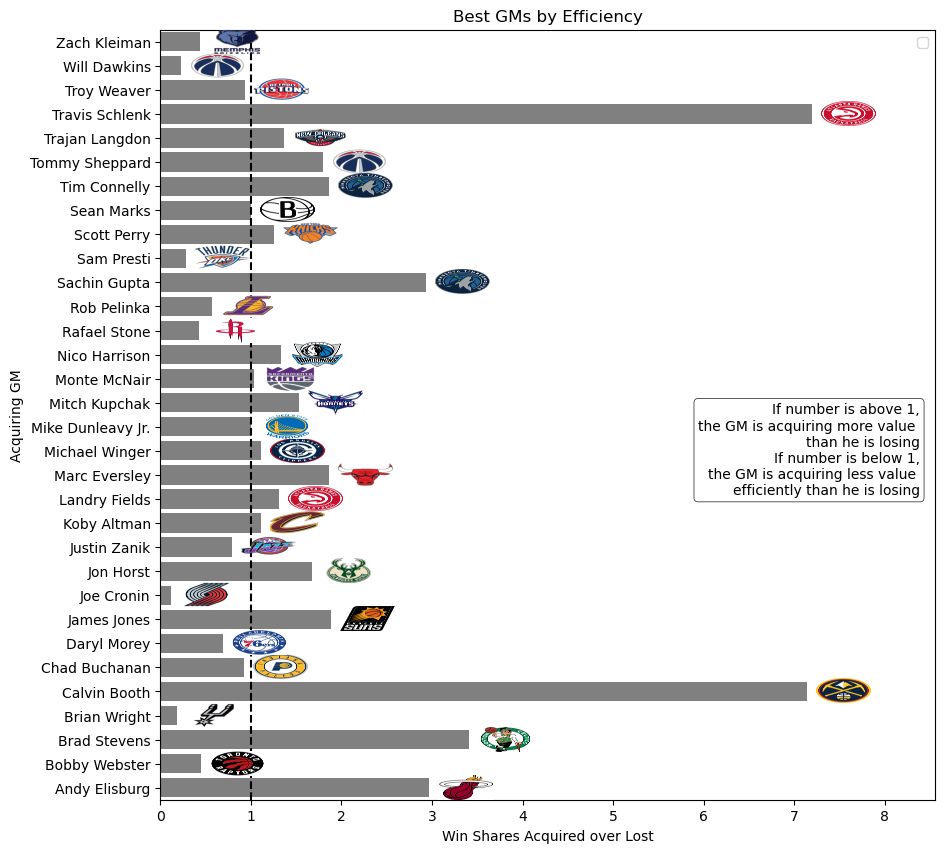

In [32]:
# Set up the plot size with reduced height
plt.figure(figsize=(10, 10))  # Adjust the height here

# Create a horizontal bar chart using seaborn
sns.barplot(y='Acquiring GM', x='final_ratio', data=grouped_difference2, color='gray')

# Add labels and title
plt.title('Best GMs by Efficiency')
plt.xlabel('Win Shares Acquired over Lost')
plt.ylabel('Acquiring GM')

# Set the x-axis limits to show only positive values
plt.xlim(0, plt.xlim()[1] + 1)  # Lower limit is set to 0, upper limit remains unchanged

# Set the y-axis limits to keep bars within a certain height
plt.ylim(-0.5, len(grouped_difference2) - 0.5)  # Adjust y-axis limits to fit the number of bars

# Add a black reference line for the modeled cost of a win share
plt.axvline(x=1, color='black', linestyle='--')

# Add an annotation with a multi-line text box aligned to the far right
plt.text(
    x=plt.xlim()[1] * 0.98,  # Position near the far right of the x-axis
    y=len(grouped_difference2) * 0.5,  # Adjusted vertical position
    s="If number is above 1,\nthe GM is acquiring more value \nthan he is losing\nIf number is below 1,\nthe GM is acquiring less value \nefficiently than he is losing",
    ha='right',  # Align text to the right
    va='top',  # Vertical alignment to the top
    color='black',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", linewidth=0.5, alpha=0.9),
)

# Add larger team logos to the right of each bar
for i, (index, row) in enumerate(grouped_difference2.iterrows()):
    team_name = row['Team Acquiring']  # Assuming 'Team Acquiring' has the team names
    logo_path = f'../logos/{team_name}.png'  # Update with actual path to logos
    
    # Load the logo image
    img = Image.open(logo_path)
    
    # Resize the image (width, height) - 100% larger than previous size
    img = img.resize((50, 25), Image.ANTIALIAS)  # Increased size to 90x44
    img = mpimg.imread(logo_path)  # Convert back to numpy array after resizing
    
    # Set the position for the logo to the right of each bar
    plt.imshow(img, aspect='auto', extent=[row['final_ratio'] + 0.1, row['final_ratio'] + 0.7, 
                                            i - 0.5, i + 0.5], zorder=10)
   

# Align y-axis labels with bars by setting the ticks and labels manually
plt.yticks(ticks=range(len(grouped_difference2)), labels=grouped_difference2['Acquiring GM'], rotation=0)

# Add a legend for the reference line
plt.legend()

# Show the plot
plt.show()

In [25]:
# Define the grade categories
grade_labels = ['F', 'D', 'C', 'B', 'A']

# Calculate the quantiles for the 'final_ratio' column (5 bins for grades A to F)
grouped_difference2['Grade'] = pd.qcut(grouped_difference2['final_ratio'], q=5, labels=grade_labels)

C:\Users\kevin\AppData\Local\Temp\ipykernel_53976\1224732151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_difference2['Grade'] = pd.qcut(grouped_difference2['final_ratio'], q=5, labels=grade_labels)


In [26]:
# Calculate the mean and standard deviation of the 'GM_Pct Change' column
mean_gm_pct_change = grouped_difference2['final_ratio'].mean()
std_gm_pct_change = grouped_difference2['final_ratio'].std()

# Create the 'z score' column by applying the Z-score formula
grouped_difference2['z score'] = (grouped_difference2['final_ratio'] - mean_gm_pct_change) / std_gm_pct_change

C:\Users\kevin\AppData\Local\Temp\ipykernel_53976\2011827807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_difference2['z score'] = (grouped_difference2['final_ratio'] - mean_gm_pct_change) / std_gm_pct_change


In [27]:
grouped_difference2.sort_values('final_ratio', ascending=False)

,Acquiring GM,Team Acquiring,AAV_sum,Acquired Player Win Shares Year 1_acquired,Count,Cost of Win Share_acquired,Losing GM,AAV,Acquired Player Win Shares Year 1_losing,Cost of Win Share_losing,final_ratio,Grade,z score
28,Travis Schlenk,ATL,13.8,3.6,2,3.833333,Travis Schlenk,12.9,0.5,25.800000,7.200000,A,3.360875
4,Calvin Booth,DEN,22.8,5.0,4,4.560000,Calvin Booth,28.8,0.7,41.142857,7.142857,A,3.326660
2,Brad Stevens,BOS,122.1,24.2,12,5.045455,Brad Stevens,73.3,7.1,10.323944,3.408451,A,1.090684
0,Andy Elisburg,MIA,51.5,8.3,2,6.204819,Andy Elisburg,23.9,2.8,8.535714,2.964286,A,0.824740
21,Sachin Gupta,MIN,20.3,4.1,2,4.951220,Sachin Gupta,20.3,1.4,14.500000,2.928571,A,0.803356
7,James Jones,PHO,87.1,14.3,8,6.090909,James Jones,60.9,7.6,8.013158,1.881579,A,0.176469
25,Tim Connelly,MIN,28.4,2.8,2,10.142857,Tim Connelly,34.1,1.5,22.733333,1.866667,A,0.167541
13,Marc Eversley,CHI,48.8,13.2,3,3.696970,Marc Eversley,51.7,7.1,7.281690,1.859155,B,0.163043
26,Tommy Sheppard,WAS,82.1,14.2,6,5.781690,Tommy Sheppard,86.5,7.9,10.949367,1.797468,B,0.126108
9,Jon Horst,MIL,77.1,15.1,5,5.105960,Jon Horst,24.9,9.0,2.766667,1.677778,B,0.054443


In [ ]:
grouped_difference2.to_csv('../outputs/trades_gm_z_scores_acquired_over_lost_2022_2024.csv', index=False)